<a href="https://colab.research.google.com/github/cgeraldes/AULAS/blob/main/CGRNN_NASDAQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Univariable Prediction

1.   Item de lista
2.   Item de lista



NASDAQ (National Association of Securities Dealers Automated Quotations) is an American stock exchange that is known for trading technology stocks and a variety of other securities. It is the second-largest stock exchange in the world by market capitalization, after the New York Stock Exchange (NYSE). NASDAQ operates an electronic trading platform, and it is known for its role in listing many technology and internet-based companies.

In [ ]:
!wget https://raw.githubusercontent.com/cgeraldes/AULAS/main/files/NASDAQ.csv

--2024-01-20 01:08:13--  https://raw.githubusercontent.com/cgeraldes/AULAS/main/files/NASDAQ.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85564 (84K) [text/plain]
Saving to: ‘NASDAQ.csv.5’

NASDAQ.csv.5        100%[===================>]  83.56K  --.-KB/s    in 0.01s   

2024-01-20 01:08:13 (5.95 MB/s) - ‘NASDAQ.csv.5’ saved [85564/85564]



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,  LSTM
from keras import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv('NASDAQ.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-16,27.573000,27.750000,27.525999,27.591999,26.198719,417000
1,2019-01-17,27.528000,27.858999,27.469000,27.773001,26.370579,383000
2,2019-01-18,27.996000,28.181999,27.822001,28.056999,26.640240,771000
3,2019-01-22,27.903000,27.927000,27.334999,27.570000,26.177832,822000
4,2019-01-23,27.693001,27.767000,27.290001,27.523001,26.133200,343000


Now, we will visualize and print the column "Close" from the DataFrame df using Matplotlib. When we reshape Y using Y.reshape(-1, 1), we are essentially converting it from a 1D array (vector) to a 2D array (matrix) where each element is a column vector. The resulting shape is (n_samples, 1).

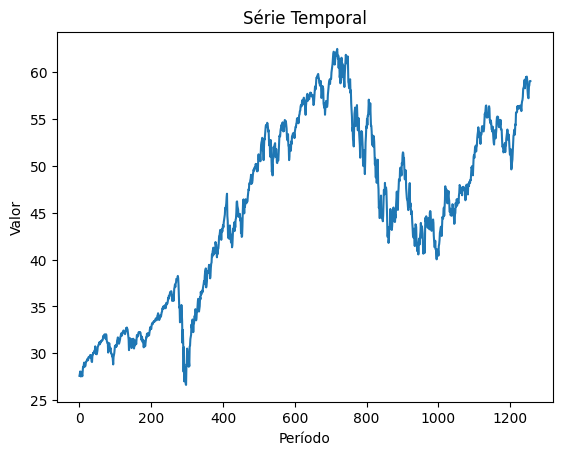

In [ ]:
L = len(df)
Y = df.iloc[:, 4]
Y = np.array(Y).reshape(-1, 1)

plt.plot(Y)
plt.title('Série Temporal')
plt.xlabel('Período')
plt.ylabel('Valor')
plt.show(block=False)


## Data Preparation

X1, X2, and X3 are created by shifting the original time series Y by one, two, and three time steps, respectively.
Each row of X concatenates three consecutive values from Y.

In [ ]:
X1= Y[0:L-3,:]
X2=Y[1:L-2,:]
X3=Y[2:L-1,:]
Y = Y[3:L,:]
X= np.concatenate([X1,X2,X3],axis=1)
print(f'X shape is {X.shape}')
print(f'Y shape is {Y.shape}')
pd.DataFrame(X)

X shape is (1254, 3)
Y shape is (1254, 1)


,0,1,2
0,27.591999,27.773001,28.056999
1,27.773001,28.056999,27.570000
2,28.056999,27.570000,27.523001
3,27.570000,27.523001,27.683001
4,27.523001,27.683001,28.021000
...,...,...,...
1249,57.549999,57.240002,57.200001
1250,57.240002,57.200001,58.430000
1251,57.200001,58.430000,58.570000
1252,58.430000,58.570000,59.020000


## Standardize Sample between {0,1}

scaler = MinMaxScaler(): Create an instance of the MinMaxScaler for the input features.

scaler.fit(X): Fit the scaler to the input features X, computing the minimum and maximum values.

X = scaler.transform(X): Transform the input features X using the fitted scaler, scaling the values to the specified range (usually between 0 and 1).

Similarly, scaler1 = MinMaxScaler() and scaler1.fit(Y) are used to create a separate scaler for the target variable Y.

Y = scaler1.transform(Y): Transform the target variable Y using the fitted scaler.

After scaling, your input features and target variable are transformed to a common scale, which can be beneficial for training machine learning models, especially when using algorithms sensitive to the scale of the input features.

Make sure to keep the fitted scalers (scaler and scaler1) if you need to inverse transform predictions back to the original scale later on. You can use scaler.inverse_transform() and scaler1.inverse_transform() for that purpose.

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
scaler1 = MinMaxScaler()
scaler1.fit(Y)
Y = scaler1.transform(Y)

In [ ]:
pd.DataFrame(X)

,0,1,2
0,0.027039,0.032090,0.040015
1,0.032090,0.040015,0.026425
2,0.040015,0.026425,0.025114
3,0.026425,0.025114,0.029578
4,0.025114,0.029578,0.039010
...,...,...,...
1249,0.862991,0.854341,0.853224
1250,0.854341,0.853224,0.887546
1251,0.853224,0.887546,0.891453
1252,0.887546,0.891453,0.904010


This reshaping is converting the original matrix X with shape (n_samples, 3 * n_features) to a 3D array with shape (n_samples, 1, 3 * n_features). The purpose of this reshaping is to fit the input requirements of some neural network architectures, particularly those that expect input data in the form of sequences.
In the reshaped array:

The first dimension (n_samples) represents the number of samples.
The second dimension (1) represents a time step or sequence length. In this case, it's set to 1, suggesting that each row is treated as a separate time step.
The third dimension (3 * n_features) represents the features at each time step.
This shape is suitable for models that expect input in the form of (batch_size, timesteps, features).

In [ ]:
X= np.reshape(X, (X.shape[0],1,X.shape[1]))

Divide sample in train and validation

## Building the Neural Network

In [ ]:
X_train = X[:190,:,:]
X_test = X[190:,:,:]
Y_train = Y[:190,:]
Y_test = Y[190:,:]
#X_test = X_train
#Y_test = Y_train

Sequential(): Initializes a sequential model, which is a linear stack of layers.

LSTM(10, activation='tanh', input_shape=(1, 3), recurrent_activation='hard_sigmoid'):

LSTM(10): Adds an LSTM layer with 10 units (or neurons).
activation='tanh': Specifies the activation function for the LSTM layer. Here, it's set to hyperbolic tangent (tanh), which is a common choice.
input_shape=(1, 3): Defines the shape of the input data expected by the model. In this case, it expects input sequences with one time step and three features.
recurrent_activation='hard_sigmoid': Specifies the activation function for the recurrent step of the LSTM. The hard sigmoid function is often used for its computational efficiency.
This model is suitable for working with sequential data with one time step and three features. If your data has a different structure, you may need to adjust the input_shape accordingly.

After defining the model, you can continue by adding more layers, compiling the model, and training it using your prepared training data (X_train and Y_train). Make sure to choose an appropriate loss function, optimizer, and metrics based on your specific task.

In [ ]:
model = Sequential()
model.add(LSTM(10,activation = 'linear',input_shape = (1,3),recurrent_activation= 'hard_sigmoid'))

In [ ]:
model.add(Dense(1))

In [ ]:
model.compile(loss= 'mean_squared_error',optimizer = 'rmsprop', metrics=[metrics.mae])
model.fit(X_train,Y_train,epochs=100,verbose=2)
Predict = model.predict(X_test)

Epoch 1/100
6/6 - 2s - loss: 0.0108 - mean_absolute_error: 0.0986 - 2s/epoch - 288ms/step
Epoch 2/100
6/6 - 0s - loss: 0.0069 - mean_absolute_error: 0.0779 - 23ms/epoch - 4ms/step
Epoch 3/100
6/6 - 0s - loss: 0.0048 - mean_absolute_error: 0.0634 - 20ms/epoch - 3ms/step
Epoch 4/100
6/6 - 0s - loss: 0.0033 - mean_absolute_error: 0.0516 - 26ms/epoch - 4ms/step
Epoch 5/100
6/6 - 0s - loss: 0.0022 - mean_absolute_error: 0.0415 - 22ms/epoch - 4ms/step
Epoch 6/100
6/6 - 0s - loss: 0.0015 - mean_absolute_error: 0.0340 - 23ms/epoch - 4ms/step
Epoch 7/100
6/6 - 0s - loss: 0.0011 - mean_absolute_error: 0.0282 - 20ms/epoch - 3ms/step
Epoch 8/100
6/6 - 0s - loss: 8.2016e-04 - mean_absolute_error: 0.0247 - 22ms/epoch - 4ms/step
Epoch 9/100
6/6 - 0s - loss: 7.0795e-04 - mean_absolute_error: 0.0225 - 23ms/epoch - 4ms/step
Epoch 10/100
6/6 - 0s - loss: 6.6536e-04 - mean_absolute_error: 0.0214 - 20ms/epoch - 3ms/step
Epoch 11/100
6/6 - 0s - loss: 6.4568e-04 - mean_absolute_error: 0.0207 - 25ms/epoch - 4

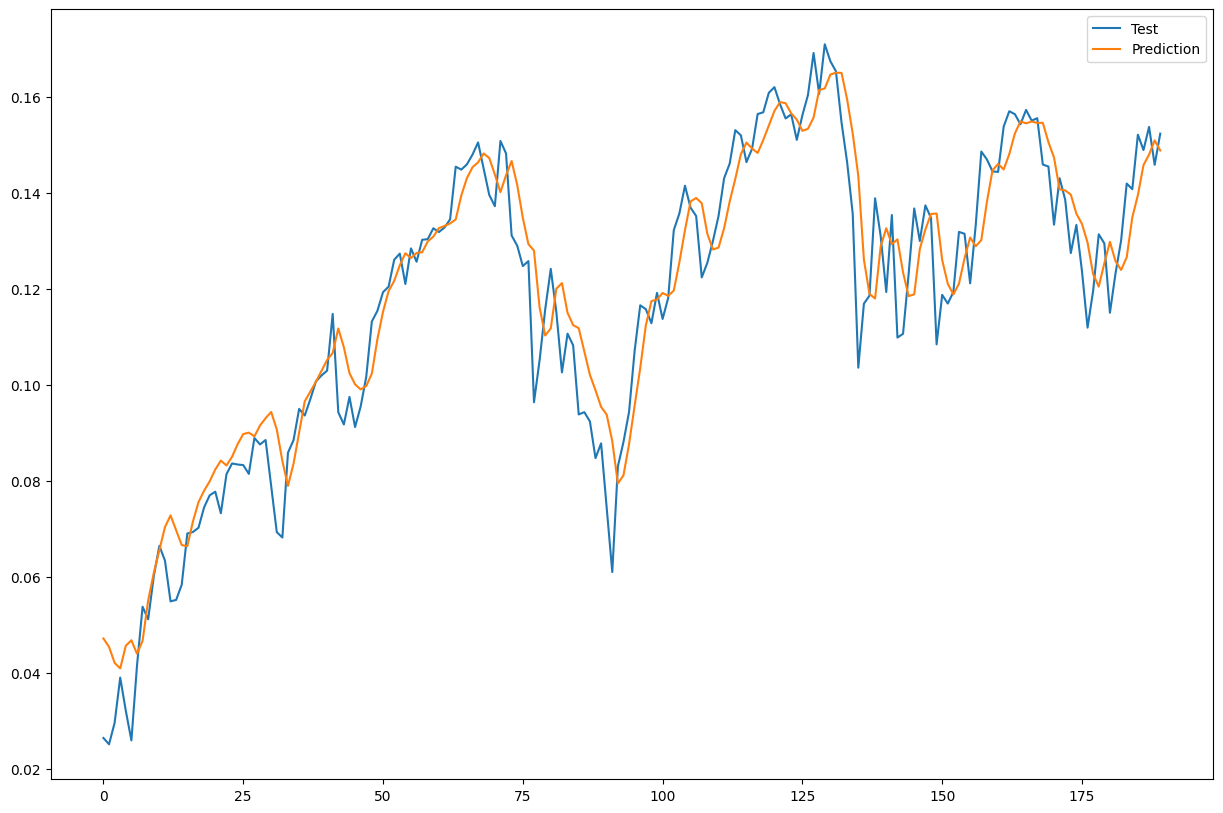

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(Y_test,label = 'Test')
plt.plot(Predict, label = 'Prediction')
plt.legend(loc='best')
plt.show()

## Considerations about Time Step

The decision to change the sampling rate (number of time steps) typically depends on the nature of your data and the requirements of your task. Here are some considerations:

Uniform Sampling:

If your data is uniformly sampled and each time step represents a consistent interval of time, changing the time step is often associated with changing the granularity of your observations.
For example, if you have daily data and you change to a time step of 2, it might mean transitioning to every two days.
Irregular Sampling:

If your data has irregular sampling intervals, you may need to preprocess the data to ensure a uniform time step before feeding it into the LSTM model.
Resampling techniques (e.g., interpolation or aggregation) can be applied to achieve a consistent time step.
Temporal Dependencies:

The choice of the time step is related to the temporal dependencies in your data. If your data exhibits patterns or relationships that are better captured with a specific time step, it's reasonable to choose that time step.
Model Definition:

When defining the LSTM model, you can specify the input_shape parameter to match the desired number of time steps and features. The model will then expect input sequences with the specified structure.
Here's an example when defining the model:

python
Copy code
model.add(LSTM(10, activation='tanh', input_shape=(n_time_steps, n_features), recurrent_activation='hard_sigmoid'))
n_time_steps: Represents the number of time steps in each input sequence.
n_features: Represents the number of features at each time step.
If you choose to change the time step, you may need to adjust the model architecture and, in some cases, reprocess your data to ensure compatibility with the new time step.

In summary, you can adjust the number of time steps when defining the model, but ensure that the change aligns with the temporal characteristics of your data and the requirements of your task. If needed, preprocess the data accordingly to achieve the desired time step.

## Batch Size considerations

When using a sequence length of 3 time steps (input sequence length) to predict the next time step (output), the appropriate batch size depends on various factors such as the size of your dataset, the memory available on your hardware, and the specific characteristics of your problem.

Here's a general guideline for choosing the batch size:

Memory Considerations:

Larger batch sizes require more memory. If your dataset is large and you have enough memory, you can experiment with larger batch sizes.
Smaller batch sizes may be necessary if memory is limited.
Training Stability:

Smaller batch sizes can introduce more noise in the weight updates, potentially making training more unstable.
Larger batch sizes might lead to smoother weight updates but could require more memory.
Performance:

Larger batch sizes can sometimes lead to faster training, especially on hardware optimized for parallel processing (e.g., GPUs).
Smaller batch sizes might converge to better solutions if there's more variability in the data.
Experimentation:

It's often beneficial to experiment with different batch sizes to find the one that works best for your specific dataset and problem.
For sequence-to-sequence models like the one you're describing, where each input sequence has 3 time steps, a common practice is to choose a batch size based on a balance between computational efficiency and training stability. A batch size in the range of 32 to 128 is often a reasonable starting point. You may need to adjust this based on the specifics of your data and available resources.

If you're using a GPU, you can try larger batch sizes to take advantage of parallel processing capabilities. If memory is a limitation, you might need to use a smaller batch size.

Ultimately, the ideal batch size is problem-dependent, and it's often determined through experimentation. You can try different batch sizes and monitor the training process, looking for signs of convergence and stability.






